# This file is for testing the camera calibraiont pipeline

In [14]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

## Exercise 1
The process of calibrating an image consists of mainly 3 steps: 1) find chessboard-corners in a dataset of images containing a chessboard. 2) Use the corner points to compute a camera matrix. 3) Use the camera matrix to undistort images.

After setting some optimization parameters we can loop over all the images in the `imgs` folder and extract the checkerboard corners.

Use any of the images in the folder `imgs` to extract the number of checkerboard corners there are on the checkerboard. Fill in the information in `nb_vertical` and `nb_horizontal` and look up the opencv [findChessboardCorners](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a) function and implement it in the below code snippet .

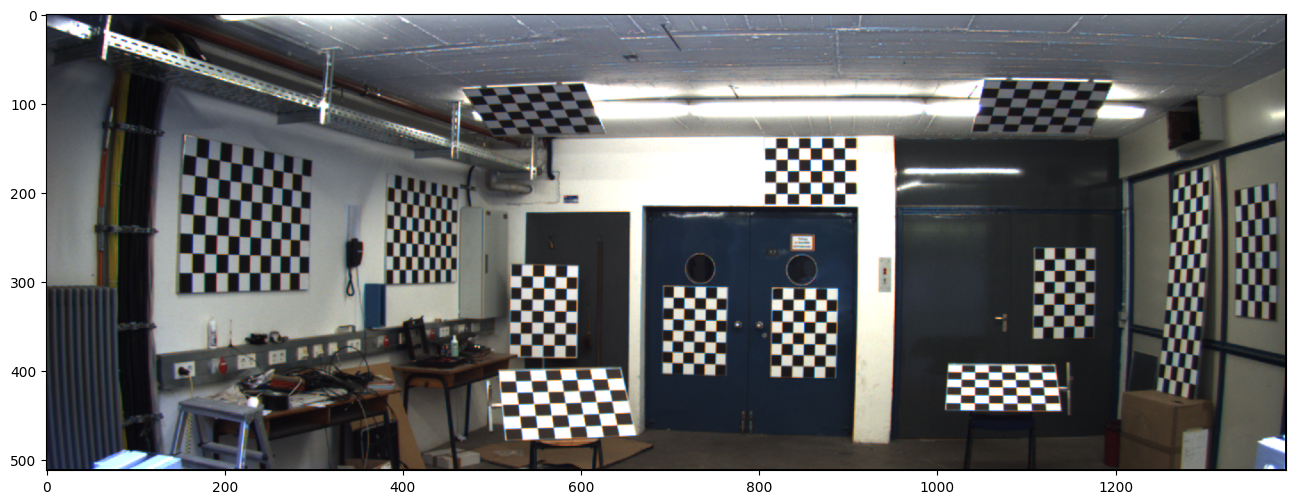

In [23]:
"""
Implement the number of vertical and horizontal corners
nb_vertical = ...
nb_horizontal = ...
"""
nb_vertical = 7
nb_horizontal = 5


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

raw_path = "../data/34759_final_project_raw/"
left_raw_path = raw_path + "calib/image_02/data/"
right_raw_path = raw_path + "calib/image_03/data/"

left_images = glob.glob(left_raw_path + '*.png')
right_images = glob.glob(right_raw_path + '*.png')

#print(left_raw_path)
#print(right_raw_path)

assert left_images
assert right_images

example_image = plt.imread(left_images[0])
plt.figure(1, (16, 28))
plt.imshow(example_image)

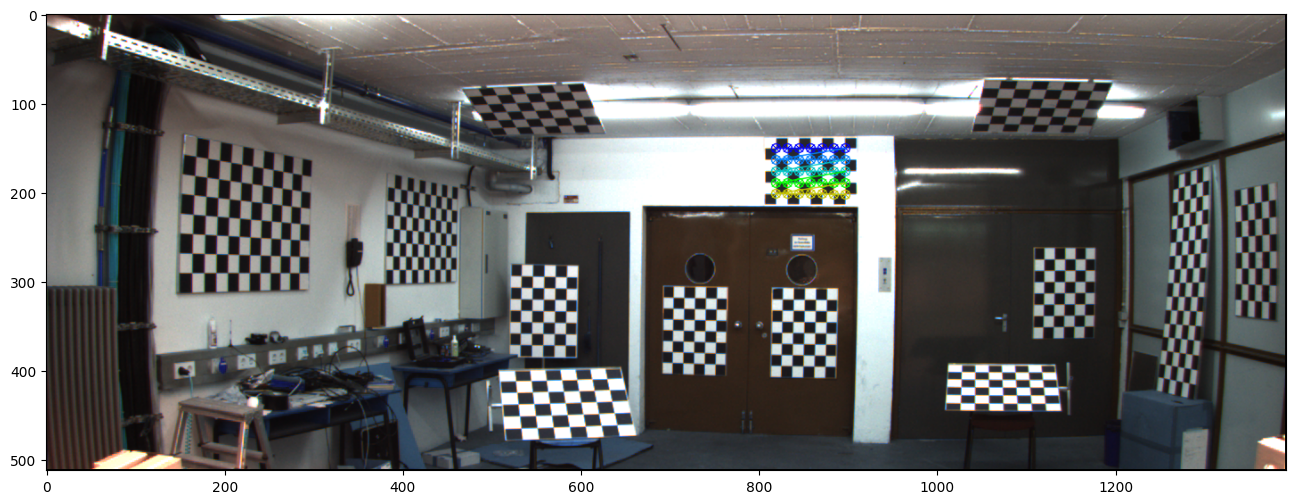

In [24]:
img = cv2.imread(left_images[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (nb_vertical, nb_horizontal), None)
if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)

    img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)
    

    plt.figure(1, (16, 28))
    plt.imshow(img)
else:
    print("Chessboard was not found")

In [13]:

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    """
    Implement findChessboardCorners here
    ret, corners = ...
    """
    ret, corners = cv2.findChessboardCorners(gray, (6,7), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nb_vertical,nb_horizontal), corners,ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
print("Closed all windows")

NameError: name 'images' is not defined

In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
img = cv2.imread('imgs/1403709067387836928.png')
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

#print(rvecs)
#print(tvecs)

In [ ]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img[...,[2,1,0]])
ax[0].set_title('Original image')
ax[1].imshow(dst[...,[2,1,0]])
ax[1].set_title('Undistorted image')

In [ ]:
# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
plt.figure(figsize=(10,10))
plt.imshow(dst[...,[2,1,0]])